In [1]:
import pandas as pd
from ebmdatalab import bq
import numpy as np

In [2]:
from ebmdatalab import bq

# save table in BQ as follows
'''SELECT pct, practice, chemical, bnf_code, bnf_name, SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity, CAST(month AS DATE) AS month 
FROM `ebmdatalab.hscic.normalised_prescribing_standard` p

LEFT JOIN `hscic.bnf` b ON p.bnf_code = b.presentation_code

WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium 
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin 
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium 
    '0212000Y0') --Simvastatin

GROUP BY 
 pct, practice, chemical, bnf_code, bnf_name, month
 
ORDER BY
month, bnf_code'''

# for practice- and chemical-level use following
'''SELECT pct, practice, chemical, SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity, CAST(month AS DATE) AS month ,
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) NOT IN (
    '0212000AAAA', --Rosuvastatin Calc_Tab 10mg (brand, generic) 
    '0212000AAAB', --Rosuvastatin Calc_Tab 20mg (brand, generic) 
    '0212000AAAC', --Rosuvastatin Calc_Tab 40mg (brand, generic) 
    '0212000B0AB', --Atorvastatin_Tab 20mg (brand, generic)
    '0212000B0AC', --Atorvastatin_Tab 40mg (brand, generic) 
    '0212000B0AD', --Atorvastatin_Tab 80mg (brand, generic)
    '0212000B0AN', --Atorvastatin_Tab 30mg (brand, generic)
    '0212000B0AP', --Atorvastatin_Tab 60mg (brand, generic)
    '0212000Y0AH') --Simvastatin_Tab 80mg (brand, generic)
    THEN items ELSE 0 END) AS low_med_dose_items

FROM `ebmdatalab.helen.prescribing_statins_all_and_lowdose` p


WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium 
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin 
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium 
    '0212000Y0') --Simvastatin

GROUP BY 
 pct, practice, chemical, month
 
ORDER BY
month'''


# Import practice-level data

sql = '''-- practice data by chemical

SELECT p.month, p.practice, chemical, 
SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity
FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
  
GROUP BY
month, practice, chemical'''


#df = bq.cached_read(sql, csv_path='statins_practice_level.zip')  # add `use_cache=False` to override
df = pd.read_csv('helen_prescribing_statins_all_and_lowdose_chem.csv')
df.head()

,pct,practice,chemical,items,actual_cost,quantity,month,low_med_dose_items
0,06A,M92011,Fluvastatin Sodium,3,72.74,168,2010-08-01,3
1,08A,G83680,Rosuvastatin Calcium,2,49.83,84,2010-08-01,1
2,10X,Y02838,Simvastatin,49,81.24,1652,2010-08-01,49
3,08W,F86001,Simvastatin & Ezetimibe,2,123.08,112,2010-08-01,2
4,08G,E86632,Simvastatin,155,332.77,7070,2010-08-01,154


In [3]:
prac = df.copy()
prac["month"]= pd.to_datetime(prac.month, utc=True)
prac["proportion_lm"] = prac["low_med_dose_items"]/prac["items"]
prac.head()

,pct,practice,chemical,items,actual_cost,quantity,month,low_med_dose_items,proportion_lm
0,06A,M92011,Fluvastatin Sodium,3,72.74,168,2010-08-01 00:00:00+00:00,3,1.000000
1,08A,G83680,Rosuvastatin Calcium,2,49.83,84,2010-08-01 00:00:00+00:00,1,0.500000
2,10X,Y02838,Simvastatin,49,81.24,1652,2010-08-01 00:00:00+00:00,49,1.000000
3,08W,F86001,Simvastatin & Ezetimibe,2,123.08,112,2010-08-01 00:00:00+00:00,2,1.000000
4,08G,E86632,Simvastatin,155,332.77,7070,2010-08-01 00:00:00+00:00,154,0.993548


### Practice population data

note running this cell takes some time

In [4]:
sql_prac_p = '''
SELECT practice, month, SUM(total_list_size) AS total_list_size
--, SUM( female_75_plus+female_65_74+female_55_64+female_45_54+male_75_plus+male_65_74+male_55_64+male_45_54) AS list_size_over_45 
FROM ebmdatalab.hscic.practice_statistics_all_years stat
GROUP BY practice, month'''

prac_p = bq.cached_read(sql_prac_p, csv_path='prac_p.csv', use_cache=False)  # add `use_cache=False` to override


prac_p["total_list_size"] = prac_p["total_list_size"].astype("float")
#prac_p["list_size_over_45"] = prac_p["list_size_over_45"].astype("float")
prac_p["month"]= pd.to_datetime(prac_p.month, utc=True)
prac_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 892170 entries, 0 to 92169
Data columns (total 3 columns):
practice           892170 non-null object
month              892170 non-null datetime64[ns, UTC]
total_list_size    892170 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 27.2+ MB


# National trends

In [5]:
national = prac.copy().groupby(["month"]).sum().reset_index()


prac_n = prac_p.groupby("month").sum().reset_index()
national = national.merge(prac_n, on=["month"])


national["items_per_thou"] = 1000*national["items"]/national["total_list_size"]
national["lmdose_items_per_thou"] = 1000*national["low_med_dose_items"]/national["total_list_size"]
national["proportion_lm"] = national["low_med_dose_items"]/national["items"]

national.head()

,month,items,actual_cost,quantity,low_med_dose_items,proportion_lm,total_list_size,items_per_thou,lmdose_items_per_thou
0,2010-10-01 00:00:00+00:00,4489263,3.315708e+07,158659485,3623327,0.807110,55218374.0,81.300166,65.618140
1,2010-11-01 00:00:00+00:00,4649310,3.412504e+07,163886937,3754116,0.807457,55218374.0,84.198604,67.986718
2,2010-12-01 00:00:00+00:00,4976000,3.655069e+07,175528148,4016546,0.807184,55218374.0,90.114932,72.739302
3,2011-01-01 00:00:00+00:00,4446690,3.228819e+07,156205627,3591797,0.807746,55256645.0,80.473398,65.002083
4,2011-02-01 00:00:00+00:00,4287507,3.101696e+07,149868554,3461122,0.807257,55256645.0,77.592604,62.637209


C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


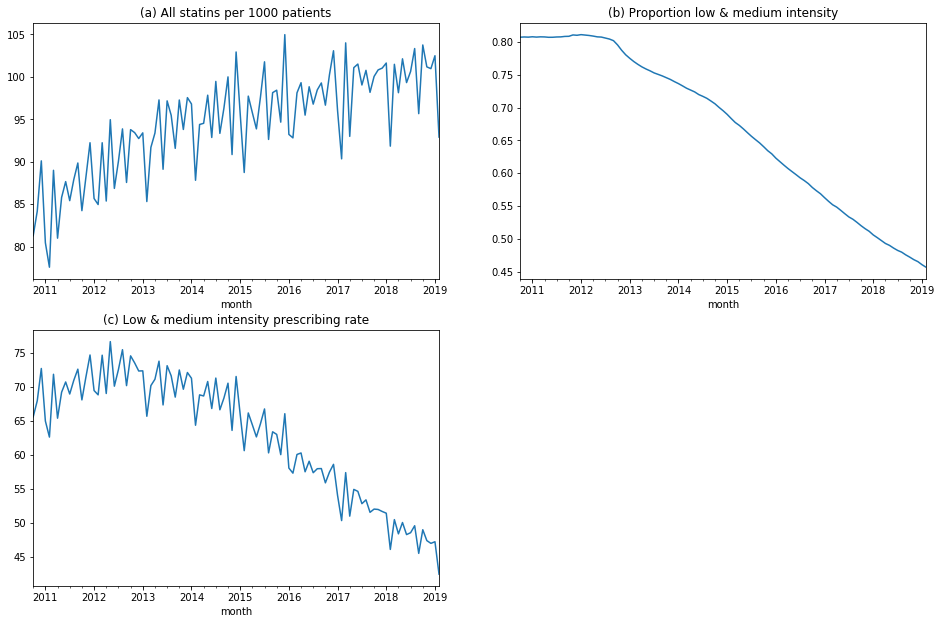

In [6]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = national.copy()

s = [(0,'items_per_thou',0,0,'(a) All statins per 1000 patients'), 
     (1,'proportion_lm',0,1,'(b) Proportion low & medium intensity'),
     (2,'lmdose_items_per_thou',1,0,'(c) Low & medium intensity prescribing rate')]

fig = plt.figure(figsize=(16,16)) 

gs = gridspec.GridSpec(3,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])
    data.plot('month', i[1], title=i[4], legend=False, ax=ax)
    
#data.plot('month', 'lmdose_items_per_thou')

plt.show()
#plot(x, y, color='green', marker='o', linestyle='dashed',
#...      linewidth=2, markersize=12)

## Deciles for practices

### Rearrange data to give items per 1000 for each chemical as a column
Also select top chemicals, grouping the rest into "other"

In [7]:
prac_deciles = prac.copy()

# group up chemicals to top 5 and "other"
conditions = [
    (prac_deciles["chemical"] == "Pravastatin Sodium"),
    (prac_deciles["chemical"] == "Rosuvastatin Calcium"),
    (prac_deciles["chemical"] == "Simvastatin"),
    (prac_deciles["chemical"] == "Atorvastatin"),
    (prac_deciles["chemical"] == "Fluvastatin Sodium")]
choices = ["Pravastatin Sodium","Rosuvastatin Calcium","Simvastatin","Atorvastatin","Fluvastatin"]
prac_deciles['chem2'] = np.select(conditions, choices, default='other statins')

prac_deciles = prac_deciles.groupby(["month","practice","chem2"],as_index=False).sum()


prac_deciles = prac_deciles.set_index(["month","practice","chem2"]).unstack()
prac_deciles["items","total"] = prac_deciles["items"].sum(axis=1)
prac_deciles["low_med_dose_items","total"] = prac_deciles["low_med_dose_items"].sum(axis=1)


prac_deciles.sort_index(axis=1,inplace=True)
prac_deciles = prac_deciles.stack().reset_index()

# join prac population data and calc items & cost per 1000
prac_deciles = prac_deciles.merge(prac_p, on=["practice","month"])
prac_deciles["items_per_thou"] = 1000*prac_deciles["items"]/prac_deciles["total_list_size"]
prac_deciles["lmdose_items_per_thou"] = 1000*prac_deciles["low_med_dose_items"]/prac_deciles["total_list_size"]
prac_deciles["proportion_lm"] = prac_deciles["low_med_dose_items"]/prac_deciles["items"]


# reduce to required columns and set index
prac_deciles = prac_deciles[["month","practice","chem2","items_per_thou","lmdose_items_per_thou", "proportion_lm"]].set_index(["month","practice","chem2"]).unstack().reset_index().replace([np.inf, -np.inf], np.nan).fillna(0)


prac_deciles.columns = ['_'.join(tup).rstrip('_') for tup in prac_deciles.columns.values]

prac_deciles.head(-20)

,month,practice,items_per_thou_Atorvastatin,items_per_thou_Fluvastatin,items_per_thou_Pravastatin Sodium,items_per_thou_Rosuvastatin Calcium,items_per_thou_Simvastatin,items_per_thou_other statins,items_per_thou_total,lmdose_items_per_thou_Atorvastatin,...,lmdose_items_per_thou_Simvastatin,lmdose_items_per_thou_other statins,lmdose_items_per_thou_total,proportion_lm_Atorvastatin,proportion_lm_Fluvastatin,proportion_lm_Pravastatin Sodium,proportion_lm_Rosuvastatin Calcium,proportion_lm_Simvastatin,proportion_lm_other statins,proportion_lm_total
0,2010-10-01 00:00:00+00:00,A81001,20.042443,1.178967,2.593728,0.943174,50.931384,0.000000,75.689696,1.414761,...,50.931384,0.000000,56.354633,0.070588,1.0,1.0,0.250000,1.000000,0.0,0.744548
1,2010-10-01 00:00:00+00:00,A81002,21.426832,0.097395,1.899196,5.843682,59.215973,0.000000,88.483078,3.749696,...,59.215973,0.000000,65.254444,0.175000,1.0,1.0,0.050000,1.000000,0.0,0.737479
2,2010-10-01 00:00:00+00:00,A81003,15.380464,0.000000,4.587156,1.079331,110.091743,0.000000,131.138694,5.666487,...,110.091743,0.000000,120.345386,0.368421,0.0,1.0,0.000000,1.000000,0.0,0.917695
3,2010-10-01 00:00:00+00:00,A81004,21.862648,0.000000,3.458498,1.482213,47.060277,0.000000,73.863636,4.323123,...,46.813241,0.000000,54.718379,0.197740,0.0,1.0,0.083333,0.994751,0.0,0.740803
4,2010-10-01 00:00:00+00:00,A81005,28.481807,0.125471,5.771644,1.882058,100.376412,0.000000,136.637390,7.151819,...,96.612296,0.000000,109.661230,0.251101,1.0,1.0,0.000000,0.962500,0.0,0.802571
5,2010-10-01 00:00:00+00:00,A81006,28.759444,0.162483,2.599724,2.599724,73.523438,0.568690,108.213502,7.067999,...,73.279714,0.568690,83.841092,0.245763,1.0,1.0,0.062500,0.996685,1.0,0.774775
6,2010-10-01 00:00:00+00:00,A81007,4.516990,0.307977,3.901037,0.205318,70.937275,0.307977,80.176573,1.026589,...,70.731958,0.307977,76.275536,0.227273,1.0,1.0,0.000000,0.997106,1.0,0.951344
7,2010-10-01 00:00:00+00:00,A81008,27.495379,0.231054,0.462107,9.011091,175.831793,2.310536,215.341959,1.617375,...,175.600739,2.310536,180.221811,0.058824,1.0,1.0,0.000000,0.998686,1.0,0.836910
8,2010-10-01 00:00:00+00:00,A81009,21.709203,0.635391,3.282855,1.164884,84.295245,0.105899,111.193477,3.918246,...,83.977550,0.105899,91.919941,0.180488,1.0,1.0,0.000000,0.996231,1.0,0.826667
9,2010-10-01 00:00:00+00:00,A81011,15.090350,0.000000,1.633987,0.672818,73.913879,0.000000,91.311034,1.826221,...,73.817762,0.000000,77.277970,0.121019,0.0,1.0,0.000000,0.998700,0.0,0.846316


### Plot practice deciles for statin prescribing by chemical per 1000 patients

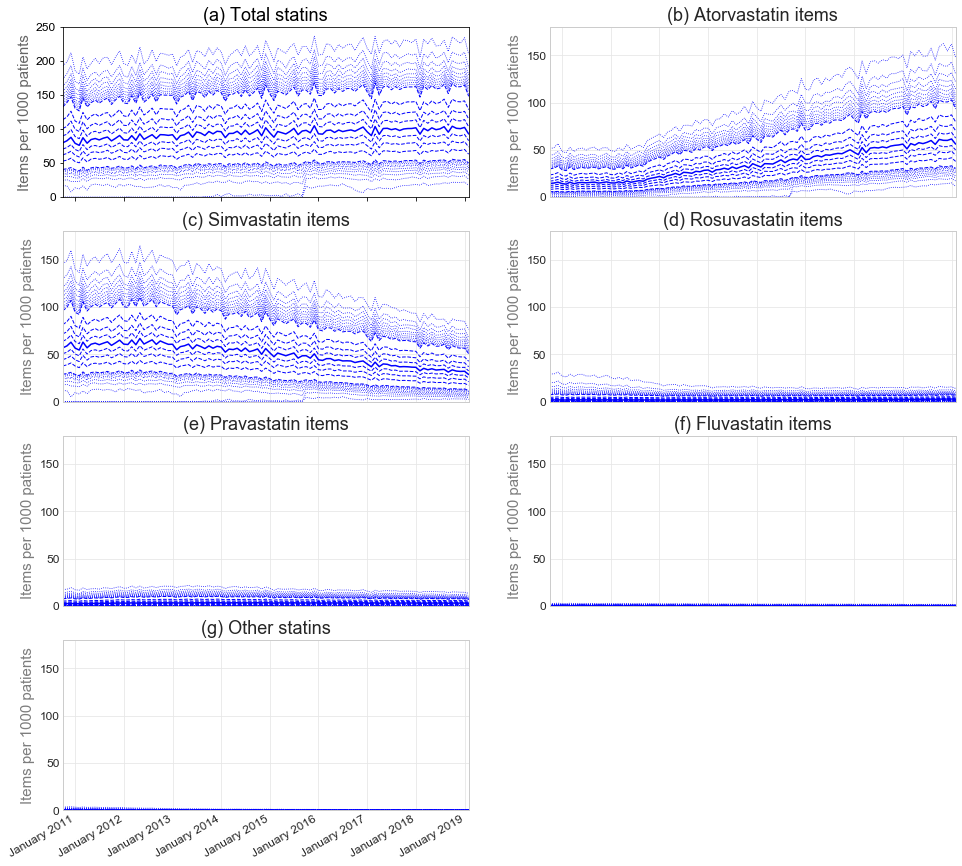

In [8]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items'),
     (5,'Fluvastatin',2,1,'(f) Fluvastatin items'),
     (6,'other statins',3,0,'(g) Other statins')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(4,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="items_per_thou_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 250])
    else:
        ax.set_ylim([0, 180])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

### Plot practice deciles for low/medium intensity items per 1000 patients

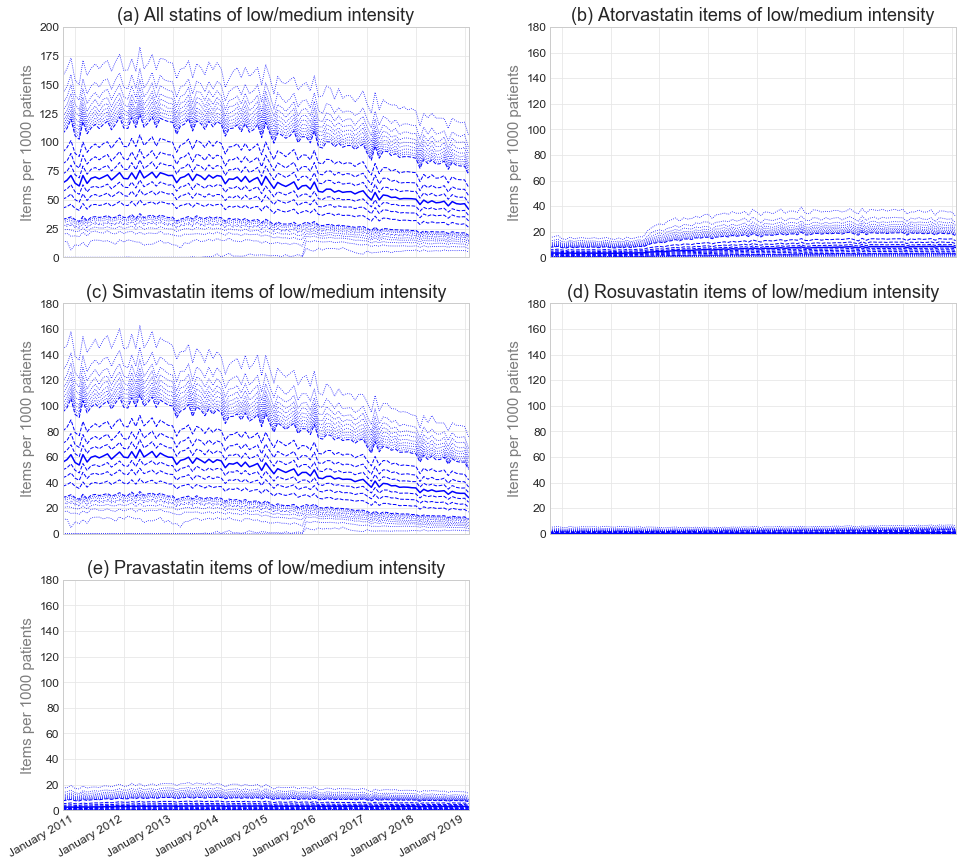

In [9]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) All statins of low/medium intensity'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items of low/medium intensity'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items of low/medium intensity'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items of low/medium intensity'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items of low/medium intensity')#,
     #(5,'Fluvastatin',2,1,'(f) Fluvastatin items of low/medium intensity'),
     #(6,'other statins',3,0,'(g) Other statins of low/medium intensity')
    ]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="lmdose_items_per_thou_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 200])
    else:
        ax.set_ylim([0, 180])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

### Plot practice deciles for low/medium intensity items as proportion of each chemical

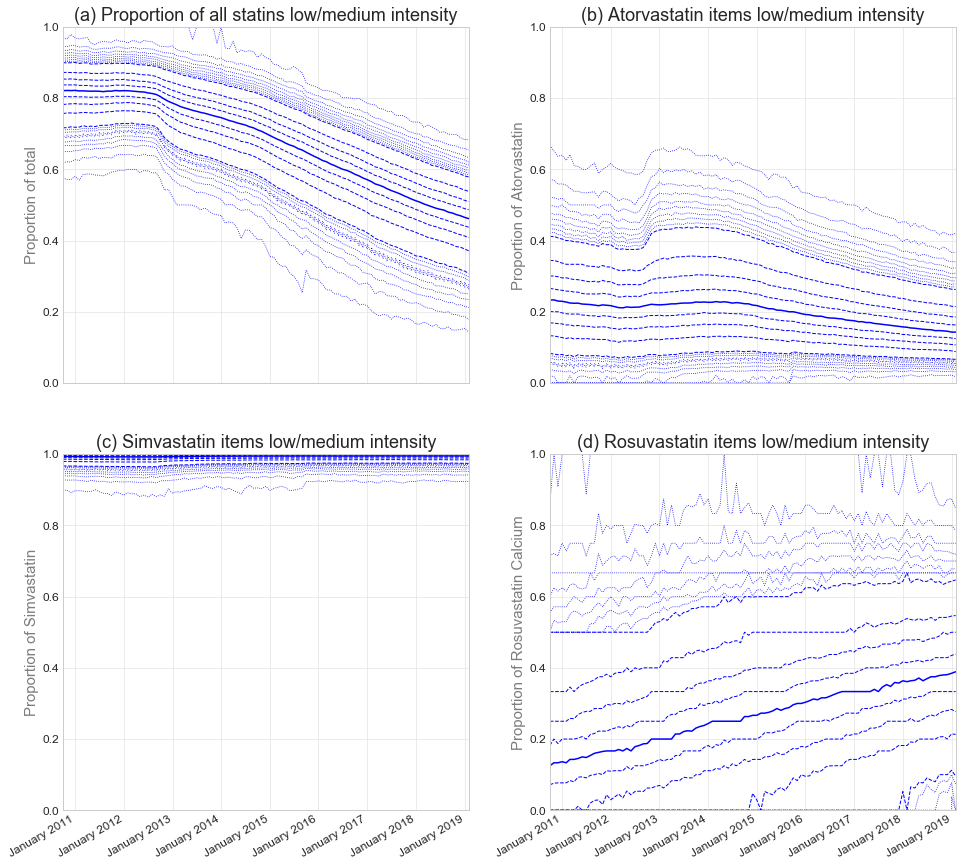

In [10]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Proportion of all statins low/medium intensity'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items low/medium intensity'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items low/medium intensity'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items low/medium intensity')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(2,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="proportion_lm_"+i[1],
        title=i[4],
        ylabel="Proportion of "+i[1],
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1])
    else:
        ax.set_ylim([0, 1])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

# Regression analysis

In [40]:
import datetime as dt

regr = prac.copy()
regr = regr.loc[pd.DatetimeIndex(regr['month']).year==2018]
regr["year"] = pd.DatetimeIndex(regr['month']).year
regr = regr.groupby(["practice","year"])["items","low_med_dose_items"].sum()

regr["proportion_lm_dose"] = regr["low_med_dose_items"]/regr["items"] 

regr.reset_index().to_csv("statins_proportion_for_regression.csv")
regr.head()

,,items,low_med_dose_items,proportion_lm_dose
practice,year,,,
A81001,2018,5261,2266,0.430717
A81002,2018,30575,12199,0.398986
A81004,2018,13974,5234,0.374553
A81005,2018,15779,7366,0.466823
A81006,2018,26783,10885,0.406415


# CCG data

In [11]:
sql = '''-- CCG data by chemical
SELECT p.month, p.pct, chemical, 
SUM(items) AS items, 
SUM(actual_cost) AS actual_cost, 
SUM(quantity) AS quantity 

FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.ccgs c
ON p.pct = c.code
  AND c. org_type = "CCG"

GROUP BY
month, pct, chemical'''


ccg = bq.cached_read(sql, csv_path='statins_ccg_level.csv')  # add `use_cache=False` to override
ccg["month"]= pd.to_datetime(ccg.month)
ccg.head()



,month,pct,chemical,items,actual_cost,quantity
0,2014-03-01,08Q,Rosuvastatin Calcium,373,10756.01,15889
1,2014-03-01,01C,Simvastatin & Ezetimibe,1,38.09,28
2,2014-03-01,99P,Acipimox,3,125.76,264
3,2014-03-01,06K,Atorvastatin,20220,34625.87,581145
4,2014-03-01,10K,Ciprofibrate,27,3626.37,1344


### CCG population data

In [12]:
sql_ccg_p = '''
SELECT pct_id AS pct, month, SUM(total_list_size) AS total_list_size,
SUM( female_75_plus+female_65_74+female_55_64+male_75_plus+male_65_74+male_55_64) AS list_size_over_55 FROM ebmdatalab.hscic.practice_statistics_all_years stat
GROUP BY pct, month'''

ccg_p = bq.cached_read(sql_ccg_p, csv_path='ccg_p.csv', use_cache=False)  # add `use_cache=False` to override


ccg_p["total_list_size"] = ccg_p["total_list_size"].astype("float")
ccg_p["list_size_over_55"] = ccg_p["list_size_over_55"].astype("float")
ccg_p["month"]= pd.to_datetime(ccg_p.month)
ccg_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30795 entries, 0 to 30794
Data columns (total 4 columns):
pct                  30760 non-null object
month                30795 non-null datetime64[ns, UTC]
total_list_size      30795 non-null float64
list_size_over_55    30795 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 962.4+ KB


# Maps

In [13]:
import numpy as np
import pandas as pd
from ebmdatalab import maps

# total items per thousand over last year

import datetime as dt
ccg_last_year =  ccg.copy()
ccg_last_year =  ccg_last_year.loc[pd.DatetimeIndex(ccg_last_year['month']).year==2018]
# join on list sizes:
ccg_last_year["month"] = pd.to_datetime(ccg_last_year["month"], utc = True)
ccg_p["month"] = pd.to_datetime(ccg_p["month"], utc = True)
ccg_last_year = ccg_last_year.merge(ccg_p, on=["pct","month"])

ccg_last_year = ccg_last_year.groupby(['pct']).agg({"items":"sum","total_list_size":"mean","list_size_over_55":"mean"}).reset_index()
ccg_last_year["items_per_thou"] = 1000*ccg_last_year["items"]/ccg_last_year["total_list_size"]
ccg_last_year["items_per_55+"] = 1000*ccg_last_year["items"]/ccg_last_year["list_size_over_55"]
#ccg_last_year["cost_per_55+"] = 1000*ccg_last_year["actual_cost"]/ccg_last_year["list_size_over_55"]
ccg_last_year.sort_values(by="items_per_thou").describe()


,items,total_list_size,list_size_over_55,items_per_thou,items_per_55+
count,1.950000e+02,1.950000e+02,195.000000,195.000000,195.000000
mean,3.743369e+05,3.035664e+05,88108.096572,1287.204058,4405.056640
std,2.088908e+05,1.813134e+05,53587.147747,362.288657,1207.256880
min,9.340500e+04,7.897006e+04,17678.780347,514.729698,2486.538978
25%,2.200335e+05,1.879890e+05,56159.071835,992.637298,3597.829360
50%,3.234200e+05,2.597903e+05,72473.450000,1287.561976,4218.239763
75%,4.685255e+05,3.350260e+05,101118.173857,1496.764103,5079.479771
max,1.251592e+06,1.314049e+06,331025.500000,2318.566931,11268.964903


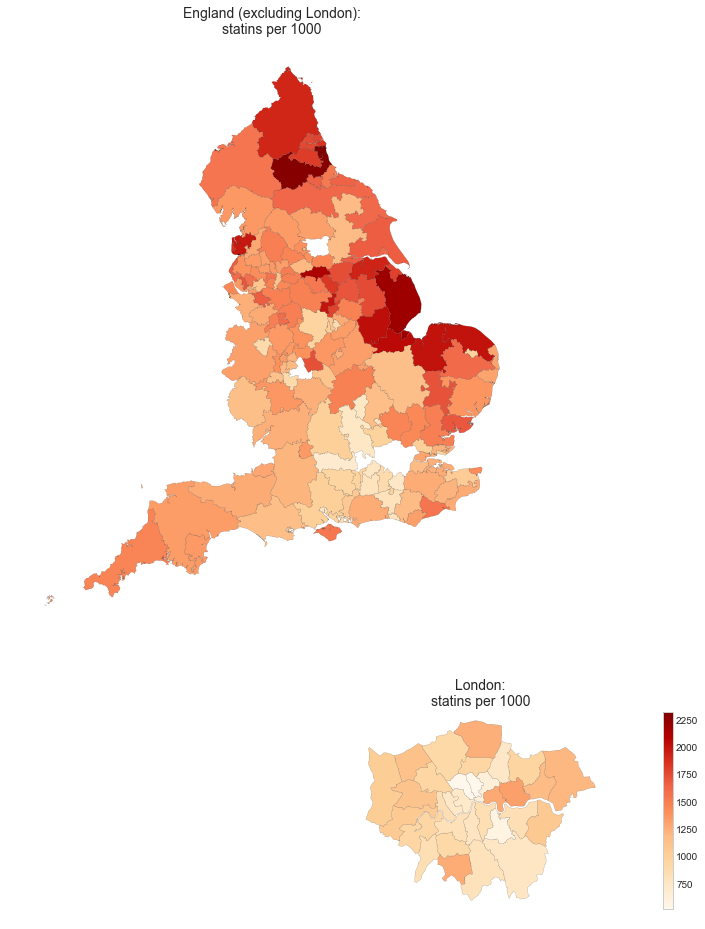

In [14]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = ccg_last_year
#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statins per 1000", column='items_per_thou', separate_london=True)
plt.show()

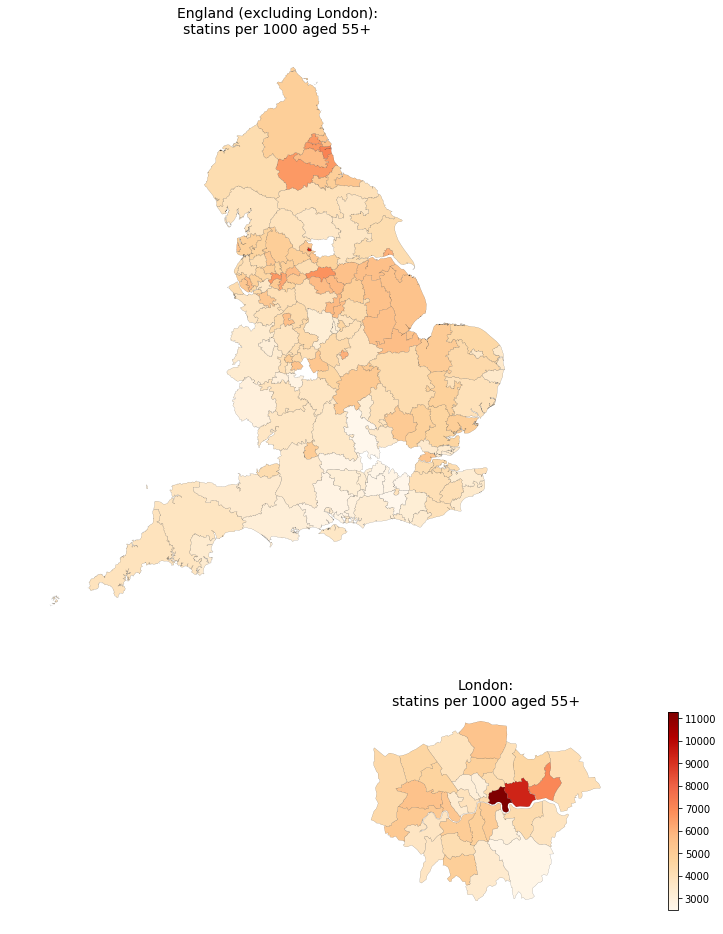

In [26]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = ccg_last_year
#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statins per 1000 aged 55+", column='items_per_55+', separate_london=True)
plt.show()

In [22]:
# Maps for measure 

sql = '''-- statin intensity measure

SELECT * FROM measures.ccg_data_statinintensity2
WHERE EXTRACT(year from month) = 2018

'''


intensity = bq.cached_read(sql, csv_path='ccg_statin_intensity.csv')  # add `use_cache=False` to override
intensity.head()

,pct_id,stp_id,regional_team_id,month,numerator,denominator,calc_value,percentile
0,02N,E54000005,Y54,2018-07-01,7098,17138,0.414167,0.103093
1,02N,E54000005,Y54,2018-01-01,7751,17646,0.439250,0.103093
2,02N,E54000005,Y54,2018-02-01,6614,15246,0.433819,0.097938
3,02N,E54000005,Y54,2018-05-01,7528,17712,0.425023,0.103093
4,02N,E54000005,Y54,2018-04-01,7290,16963,0.429759,0.108247


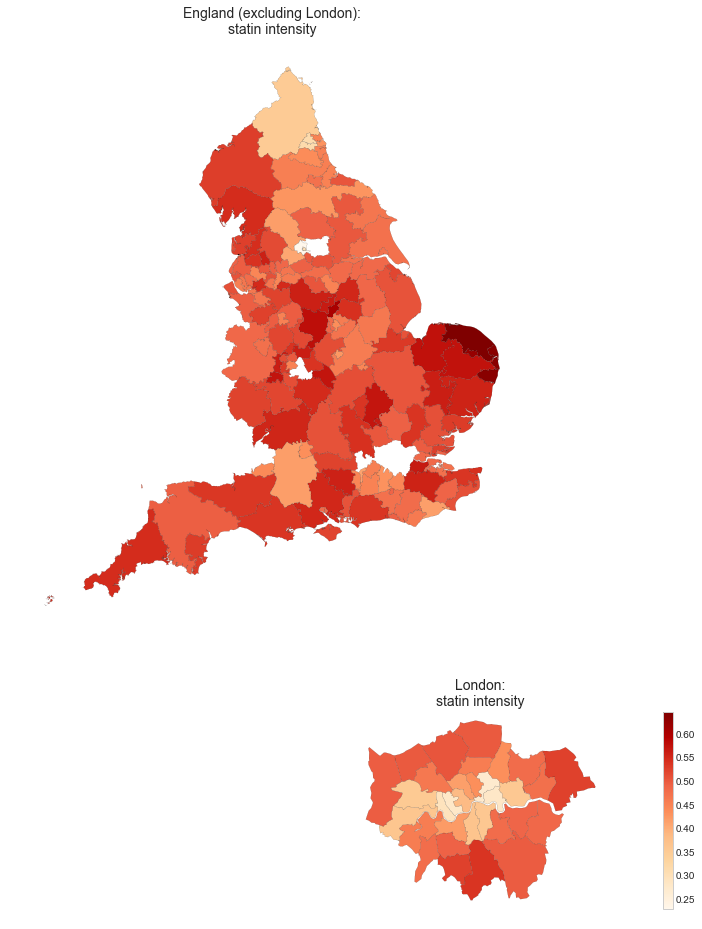

In [23]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = intensity.groupby("pct_id")["numerator","denominator"].sum().reset_index().rename(columns={"pct_id":"pct"})
data["calc_value"] = data["numerator"]/data["denominator"]

#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statin intensity", column='calc_value', separate_london=True)
plt.show()

# individual formulations

In [25]:

sql = '''SELECT p.practice, p.month,
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000B0AA','0212000B0AL') THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_10mg_quant, 
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000B0AB', '0212000B0AE', '0212000B0AM') THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_20mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AC' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_40mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AD' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_80mg_quant, 
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000Y0AA','0212000Y0AC') THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_10mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AB' OR bnf_code LIKE '0212000Y0%AE' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_20mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AD' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_40mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AH' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_80mg_quant, 

SUM(CASE WHEN bnf_code LIKE '0212000B0%AB' THEN items ELSE 0 END)/SUM(items) AS atorvastatin_20mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000B0%AD' THEN items ELSE 0 END)/SUM(items) AS atorvastatin_80mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AB' OR bnf_code LIKE '0212000Y0%AE' THEN items ELSE 0 END)/SUM(items) AS simvastatin_20mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AD' THEN items ELSE 0 END)/SUM(items) AS simvastatin_40mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AH' THEN items ELSE 0 END)/SUM(items) AS simvastatin_80mg_items, 

SUM(items) as total_items,
SUM(quantity) as total_quantity

FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
  
WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium
    '0212000Y0') --Simvastatin
  
GROUP BY
practice, month'''

dose = bq.cached_read(sql, csv_path='statins_dose_practice_level.zip')  # add `use_cache=False` to override
dose["month"] = pd.to_datetime(dose.month)

dose.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,month,atorvastatin_10mg_quant,atorvastatin_20mg_quant,atorvastatin_40mg_quant,atorvastatin_80mg_quant,simvastatin_10mg_quant,simvastatin_20mg_quant,simvastatin_40mg_quant,simvastatin_80mg_quant,atorvastatin_20mg_items,atorvastatin_80mg_items,simvastatin_20mg_items,simvastatin_40mg_items,simvastatin_80mg_items,total_items,total_quantity
0,C84121,2014-03-01,0.014451,0.130058,0.057803,0.034682,0.017341,0.268786,0.426301,0.002890,0.131579,0.035088,0.269006,0.421053,0.002924,342,9688
1,C87022,2014-03-01,0.041129,0.209947,0.160689,0.030607,0.038259,0.062171,0.386418,0.010521,0.211538,0.030769,0.061538,0.384615,0.010577,1040,29274
2,H85031,2014-03-01,0.098556,0.093514,0.092138,0.014669,0.044006,0.402017,0.174192,0.003667,0.087081,0.019139,0.386603,0.213397,0.001914,1045,30541
3,K84037,2014-03-01,0.129825,0.104475,0.102170,0.034569,0.029191,0.196082,0.347993,0.005377,0.101195,0.035857,0.195219,0.346614,0.005578,1255,36449
4,B81644,2014-03-01,0.055644,0.196608,0.051934,0.018548,0.069555,0.207737,0.230922,0.003710,0.180392,0.019608,0.184314,0.270588,0.003922,255,7548


In [26]:
# join prac population data and calc items & quantity per 1000
dose["month"] = pd.to_datetime(dose.month, utc=True)# join prac population data and calc items & quantity per 1000

dose2 = dose.merge(prac_p, on=["practice","month"])
dose2["items_per_thou"] = 1000*dose2["total_items"]/dose2["total_list_size"]
dose2["quantity_per_thou"] = 1000*dose2["total_quantity"]/dose2["total_list_size"]

dose2.head()

,practice,month,atorvastatin_10mg_quant,atorvastatin_20mg_quant,atorvastatin_40mg_quant,atorvastatin_80mg_quant,simvastatin_10mg_quant,simvastatin_20mg_quant,simvastatin_40mg_quant,simvastatin_80mg_quant,atorvastatin_20mg_items,atorvastatin_80mg_items,simvastatin_20mg_items,simvastatin_40mg_items,simvastatin_80mg_items,total_items,total_quantity,total_list_size,items_per_thou,quantity_per_thou
0,C84121,2014-03-01 00:00:00+00:00,0.014451,0.130058,0.057803,0.034682,0.017341,0.268786,0.426301,0.002890,0.131579,0.035088,0.269006,0.421053,0.002924,342,9688,2428.0,140.856672,3990.115321
1,C87022,2014-03-01 00:00:00+00:00,0.041129,0.209947,0.160689,0.030607,0.038259,0.062171,0.386418,0.010521,0.211538,0.030769,0.061538,0.384615,0.010577,1040,29274,6575.0,158.174905,4452.319392
2,H85031,2014-03-01 00:00:00+00:00,0.098556,0.093514,0.092138,0.014669,0.044006,0.402017,0.174192,0.003667,0.087081,0.019139,0.386603,0.213397,0.001914,1045,30541,11310.0,92.396110,2700.353669
3,K84037,2014-03-01 00:00:00+00:00,0.129825,0.104475,0.102170,0.034569,0.029191,0.196082,0.347993,0.005377,0.101195,0.035857,0.195219,0.346614,0.005578,1255,36449,16271.0,77.131092,2240.120460
4,B81644,2014-03-01 00:00:00+00:00,0.055644,0.196608,0.051934,0.018548,0.069555,0.207737,0.230922,0.003710,0.180392,0.019608,0.184314,0.270588,0.003922,255,7548,2212.0,115.280289,3412.296564


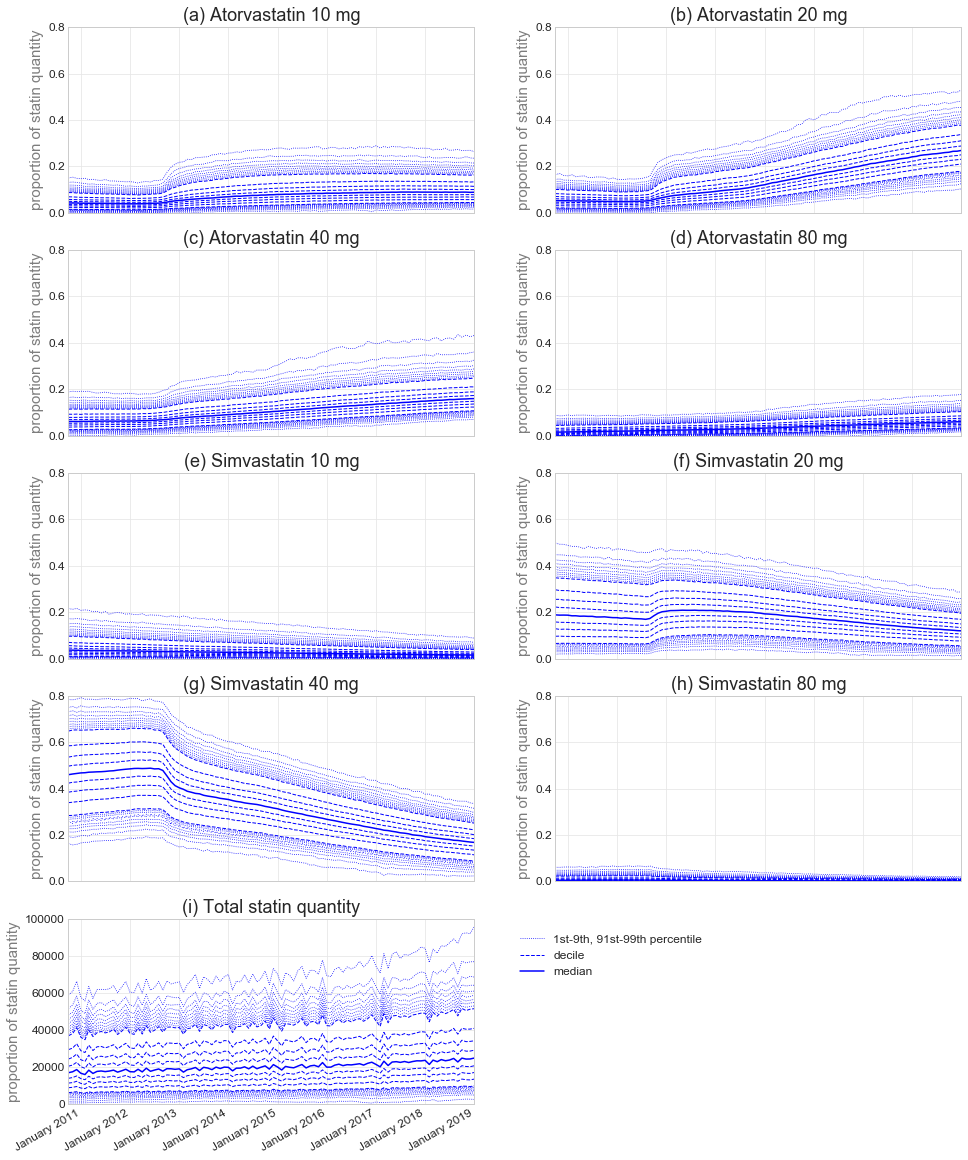

In [31]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = dose2.copy()

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'atorvastatin_10mg_quant',0,0,'(a) Atorvastatin 10 mg'), 
     (1,'atorvastatin_20mg_quant',0,1,'(b) Atorvastatin 20 mg'), 
     (2,'atorvastatin_40mg_quant',1,0,'(c) Atorvastatin 40 mg'), 
     (3,'atorvastatin_80mg_quant',1,1,'(d) Atorvastatin 80 mg'), 
     (4,'simvastatin_10mg_quant',2,0,'(e) Simvastatin 10 mg'),
     (5,'simvastatin_20mg_quant',2,1,'(f) Simvastatin 20 mg'),
     (6,'simvastatin_40mg_quant',3,0,'(g) Simvastatin 40 mg'),
     (7,'simvastatin_80mg_quant',3,1,'(h) Simvastatin 80 mg'),
     (8,'total_quantity',4,0,'(i) Total statin quantity')]


fig = plt.figure(figsize=(16,22)) 


gs = gridspec.GridSpec(5,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[0]==8: # set positions at which to display the legend
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column=i[1],
        title=i[4],
        ylabel="proportion of statin quantity",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==8:
        ax.set_ylim([0, 100000])
    else:
        ax.set_ylim([0, 0.8])

# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()